In [88]:
import yfinance as yf
import os
import pandas as pd

In [89]:
btc_ticker = yf.Ticker("BTC-USD")

In [90]:
if os.path.exists("btc.csv"):
    btc = pd.read_csv("btc.csv", index_col=0)
else:
    btc = btc_ticker.history(period="max")
    btc.to_csv("btc.csv")

In [91]:
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,25245861652,0,0
2022-09-05,19988.789062,20031.160156,19673.046875,19812.371094,28813460025,0,0
2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,43403978910,0,0


In [92]:
btc.index = pd.to_datetime(btc.index)

In [93]:
del btc["Dividends"]
del btc["Stock Splits"]

In [94]:
btc.columns = [c.lower() for c in btc.columns]

<AxesSubplot:xlabel='Date'>

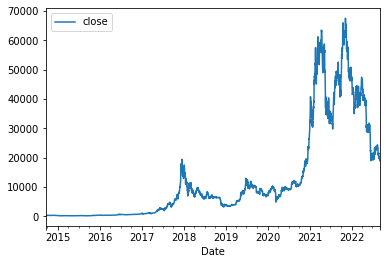

In [95]:
btc.plot.line(y="close", use_index=True)

In [96]:
wiki = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True)

In [97]:
wiki

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2022-09-04,0.400000,-0.108480,0.150000
2022-09-05,0.400000,-0.108480,0.150000
2022-09-06,0.433333,-0.081502,0.150000
2022-09-07,0.433333,-0.081502,0.150000


In [98]:
btc = btc.merge(wiki, left_index=True, right_index=True)

In [99]:
btc["tomorrow"] = btc["close"].shift(-1)

In [100]:
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)

In [101]:
btc["target"].value_counts()

1    1563
0    1351
Name: target, dtype: int64

In [102]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232759,0.532718,394.795990,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,25245861652,0.400000,-0.108480,0.150000,19812.371094,0
2022-09-05,19988.789062,20031.160156,19673.046875,19812.371094,28813460025,0.400000,-0.108480,0.150000,18837.667969,0
2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,43403978910,0.433333,-0.081502,0.150000,19290.324219,1
2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,35239757134,0.433333,-0.081502,0.150000,19337.371094,1


In [103]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = btc.iloc[:-200]
test = btc.iloc[-200:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=50, random_state=1)

In [104]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.48484848484848486

In [105]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [106]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [107]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(btc, model, predictors)

In [108]:
predictions["predictions"].value_counts()

1    1084
0     735
Name: predictions, dtype: int64

In [109]:
precision_score(predictions["target"], predictions["predictions"])

0.5009225092250923

In [110]:
def compute_rolling(btc):
    horizons = [2,7,60,365]
    new_predictors = ["close", "sentiment", "neg_sentiment"]

    for horizon in horizons:
        rolling_averages = btc.rolling(horizon, min_periods=1).mean()

        ratio_column = f"close_ratio_{horizon}"
        btc[ratio_column] = btc["close"] / rolling_averages["close"]
        
        edit_column = f"edit_{horizon}"
        btc[edit_column] = rolling_averages["edit_count"]

        rolling = btc.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        btc[trend_column] = rolling["target"]

        new_predictors+= [ratio_column, trend_column, edit_column]
    return btc, new_predictors

In [111]:
btc, new_predictors = compute_rolling(btc.copy())

In [112]:
predictions = backtest(btc, model, new_predictors)

In [113]:
precision_score(predictions["target"], predictions["predictions"])

0.5386289445048966

In [114]:
predictions

,target,predictions
2017-09-16,0,1
2017-09-17,1,0
2017-09-18,0,0
2017-09-19,0,1
2017-09-20,0,1
...,...,...
2022-09-04,0,1
2022-09-05,0,1
2022-09-06,1,1
2022-09-07,1,1
